# Model Evaluation

The predictions are stored as csv files in the folder './Predicted Data_csv format/'

Example of file name: 'Sub1_treadmill_walk_LF_HS.csv'

The model is evaluated in terms of 
- F1 score
- Percentage of true positives
- Mean of the absolute difference in time between true positives and corresponding GT events

Each event is either HS (which consists of either left foot heel strikes or right foot heel strikes), or TO (which consists of left foot heel strike)

The first step to select the activity and event of interest

Thus, for each subject. event we need to calculate:
- Number of true positives
- Number of false postives
- Number of false negatives
- F1 Score
- Mean of the absolute difference in time between true positives and corresponding GT events

We will define functions to calculate these metrics and apply them to each subject and foot (left and right)
Then we will save the results in a .csv file from which we can view the overall statistics

# Note: before you run the code

You can adjust the activity and event in the next cell.
Some parts are specific to indoors/outdoors, so you will need to comment the part if needed, and uncomment it it's if not needed.

In [1]:
import pandas as pd

In [2]:
# 0. Select if indoors or outdoors

ENVIRONMENT = 'indoors'
# ENVIRONMENT = 'outdoors'

###############################################
######## Specific to indoors only #############
###############################################

RANGE_LOW = 1
RANGE_HIGH = 12

###############################################
######## Specific to outdoors only ############
###############################################

# RANGE_LOW = 12
# RANGE_HIGH = 21

# 1. Select activity and event of interest

###### Select Activity ######
# indoors
ACTIVITY_LIST = ['treadmill_walk','treadmill_walknrun','treadmill_run','treadmill_all','indoor_walk','indoor_run','indoor_walknrun']
# outdoors
# ACTIVITY_LIST = ['outdoor_walk','outdoor_run','outdoor_walknrun']

###### Select Event ######

EVENT_LIST = ['HS','TO']

# 2. Select directories where predictions are stored and results are saved
PREDICTIONS_PATH = './Predicted Data_model_csv format/'
SAVE_PATH = './Results_model_csv format/'

# 2. Functions to calculate the metrics of interest

In [3]:
# import predictions
def import_predictions (subject_id_as_string, activity_as_string, foot_event_as_string):
    df = pd.read_csv(PREDICTIONS_PATH + 'Sub'+ subject_id_as_string +'_'+ activity_as_string + '_'+ foot_event_as_string + '.csv', header = 0)
    df = df.drop(df.columns[0], axis=1)
    return df

In [4]:
# calculate true positives, false positives, false negatives 
# temporal tolerance of +/- 5 samples
def calc_true_positive(df):
    true_positive = 0 
    for i in range(len(df)):
        if i>=5 and i+5<len(df) and df['predicted'][i] == 1:
               if df['actual'][i-5]==1 or df['actual'][i-4]==1 or df['actual'][i-3]==1 or df['actual'][i-2]==1 or df['actual'][i-1]==1 or df['actual'][i]==1 or df['actual'][i+1]==1 or df['actual'][i+2]==1 or df['actual'][i+3]==1 or df['actual'][i+4]==1 or df['actual'][i+5]==1: 
                    true_positive +=1
    return true_positive

def calc_false_positive(df):
    false_positive = 0 
    for i in range(len(df)):
        if i>=5 and i+5<len(df) and df['predicted'][i] == 1:
               if df['actual'][i-5]==0 and df['actual'][i-4]==0 and df['actual'][i-3]==0 and df['actual'][i-2]==0 and df['actual'][i-1]==0 and df['actual'][i]==0 and df['actual'][i+1]==0 and df['actual'][i+2]==0 and df['actual'][i+3]==0 and df['actual'][i+4]==0 and df['actual'][i+5]==0: 
                    false_positive +=1
    return false_positive

def calc_false_negative(df):
    false_negative = 0 
    for i in range(len(df)):
        if i>=5 and i+5<len(df) and df['actual'][i] == 1:
               if df['predicted'][i-5]==0 and df['predicted'][i-4]==0 and df['predicted'][i-3]==0 and df['predicted'][i-2]==0 and df['predicted'][i-1]==0 and df['predicted'][i]==0 and df['predicted'][i+1]==0 and df['predicted'][i+2]==0 and df['predicted'][i+3]==0 and df['predicted'][i+4]==0 and df['predicted'][i+5]==0:
                    false_negative +=1
    return false_negative

In [5]:
# calculate mean of the absolute difference in time between true positives and corresponding GT events

def calc_mean_abs_time_difference(df):
    true_positive = 0
    total_error = 0
    for i in range(len(df)):
        if df['predicted'][i] == 1:
            for j in range(-5,6,1):
                if i>=5 and i+j<len(df) and df['actual'][i+j] ==1:
                    total_error+=abs(j)
                    true_positive +=1
    mean_error = total_error/true_positive
    return mean_error

# 3. Apply functions to each subject and save the results to a .csv file

In [6]:
activity = []
event = []
dataset_id = []
true_pos = []
false_pos =[]
false_neg = []
precision = []
recall = []
F1 = []
mean_abs_time_diff = []

for ACTIVITY in ACTIVITY_LIST:
    for EVENT in EVENT_LIST:
        for i in range (RANGE_LOW, RANGE_HIGH, 1):
            for j in ['LF_', 'RF_']:
                SUBJECT_ID = str(i) # Subject ID
                FOOT_EVENT =  j + EVENT # Foot and Event
                current_df = import_predictions(SUBJECT_ID, ACTIVITY, FOOT_EVENT) # Import the corresponding dataset

                DATASET_ID = 'Sub' + SUBJECT_ID + '_' + FOOT_EVENT # for writing to the csv later, so that we know which dataset the metrics came from 
                true_positive = calc_true_positive(current_df)
                false_positive = calc_false_positive(current_df)
                false_negative = calc_false_negative(current_df)
                if true_positive !=0 or false_positive !=0:
                    precision_score = true_positive / (true_positive + false_positive)
                else: 
                    precision_score = 0 # case when no events detected
                recall_score = true_positive / (true_positive + false_negative)
                if precision_score + recall_score != 0:
                    F1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
                else:
                    F1_score = 0 # case when no events detected
                if true_positive !=0:
                    mean_error = calc_mean_abs_time_difference(current_df)
                else:
                    mean_error = 1000 # case when no events detected
                    
                activity.append(ACTIVITY)
                event.append(EVENT)
                dataset_id.append(DATASET_ID)
                true_pos.append(true_positive)
                false_pos.append(false_positive)
                false_neg.append(false_negative)
                precision.append(precision_score)
                recall.append(recall_score)
                F1.append(F1_score)
                mean_abs_time_diff.append(mean_error)        

In [7]:
RESULTS_DF = pd.DataFrame(list(zip(activity, event, dataset_id, true_pos, false_pos, false_neg, precision, recall, F1, mean_abs_time_diff)),
  columns=['activity','event','dataset_id', 'true_pos', 'false_pos', 'false_neg', 'precision', 'recall', 'F1', 'mean_abs_time_diff'])

In [8]:
RESULTS_DF

,activity,event,dataset_id,true_pos,false_pos,false_neg,precision,recall,F1,mean_abs_time_diff
0,treadmill_walk,HS,Sub1_LF_HS,729,28,0,0.963012,1.000000,0.981157,1.407407
1,treadmill_walk,HS,Sub1_RF_HS,554,2,0,0.996403,1.000000,0.998198,1.353791
2,treadmill_walk,HS,Sub2_LF_HS,31,0,81,1.000000,0.276786,0.433566,0.870968
3,treadmill_walk,HS,Sub2_RF_HS,4,0,95,1.000000,0.040404,0.077670,2.500000
4,treadmill_walk,HS,Sub3_LF_HS,315,204,0,0.606936,1.000000,0.755396,2.317460
5,treadmill_walk,HS,Sub3_RF_HS,528,94,0,0.848875,1.000000,0.918261,1.176136
6,treadmill_walk,HS,Sub4_LF_HS,213,31,0,0.872951,1.000000,0.932166,0.488263
7,treadmill_walk,HS,Sub4_RF_HS,418,0,0,1.000000,1.000000,1.000000,1.165072
8,treadmill_walk,HS,Sub5_LF_HS,966,90,0,0.914773,1.000000,0.955490,1.849896
9,treadmill_walk,HS,Sub5_RF_HS,425,50,0,0.894737,1.000000,0.944444,1.101176


In [9]:
# write results to .csv
RESULTS_DF.to_csv(SAVE_PATH+ ENVIRONMENT + '.csv', encoding='utf-8')

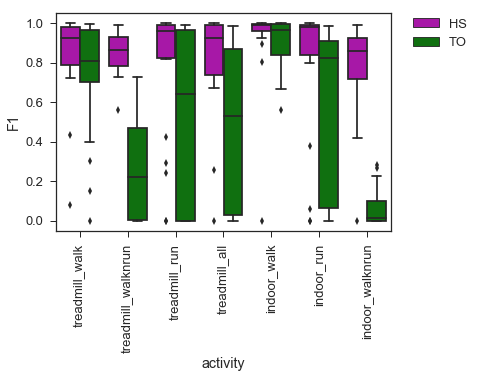

In [12]:
# Plot F1 Score
import seaborn as sns
sns.set(style="ticks", palette="pastel")
sns.set_context("notebook", font_scale=1.3)

g = sns.boxplot(x="activity", y="F1",
            hue="event", palette=["m", "g"],
            data=RESULTS_DF)

g.set_xticklabels(g.get_xticklabels(),rotation=90)
# g.set_xticklabels(g.get_xticklabels())

import matplotlib.pyplot as plt
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

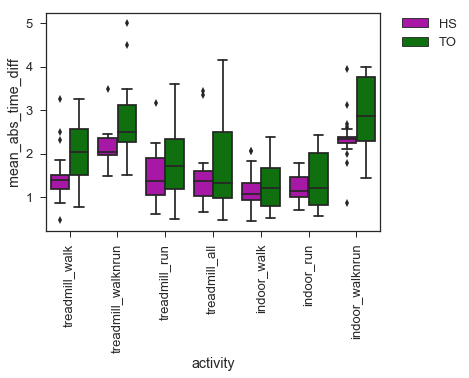

In [11]:
# Plot Mean Absolute Error
RESULTS_DF_MAE = RESULTS_DF[RESULTS_DF['true_pos']!=0]

import seaborn as sns
sns.set(style="ticks", palette="pastel")
sns.set_context("notebook", font_scale=1.3)

g = sns.boxplot(x="activity", y="mean_abs_time_diff",
            hue="event", palette=["m", "g"],
            data=RESULTS_DF_MAE)

g.set_xticklabels(g.get_xticklabels(),rotation=90)
# g.set_xticklabels(g.get_xticklabels())

import matplotlib.pyplot as plt
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)